<a href="https://colab.research.google.com/github/gatienseven7/Adversarial_Robustness_Challenge/blob/main/Mnist_Fgsm_Adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.8706 - loss: 0.4716 - val_accuracy: 0.9792 - val_loss: 0.0767
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.9789 - loss: 0.0711 - val_accuracy: 0.9857 - val_loss: 0.0535
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.9862 - loss: 0.0472 - val_accuracy: 0.9862 - val_loss: 0.0518
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.9902 - loss: 0.0330 - val_accuracy: 0.9860 - val_loss: 0.0539
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - accuracy: 0.9922 - loss: 0.0258 - val_accuracy: 0.9875 - val_loss: 0.0492
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9785 - loss: 0.0633
Test Accuracy (clean): 0.984000027179718
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

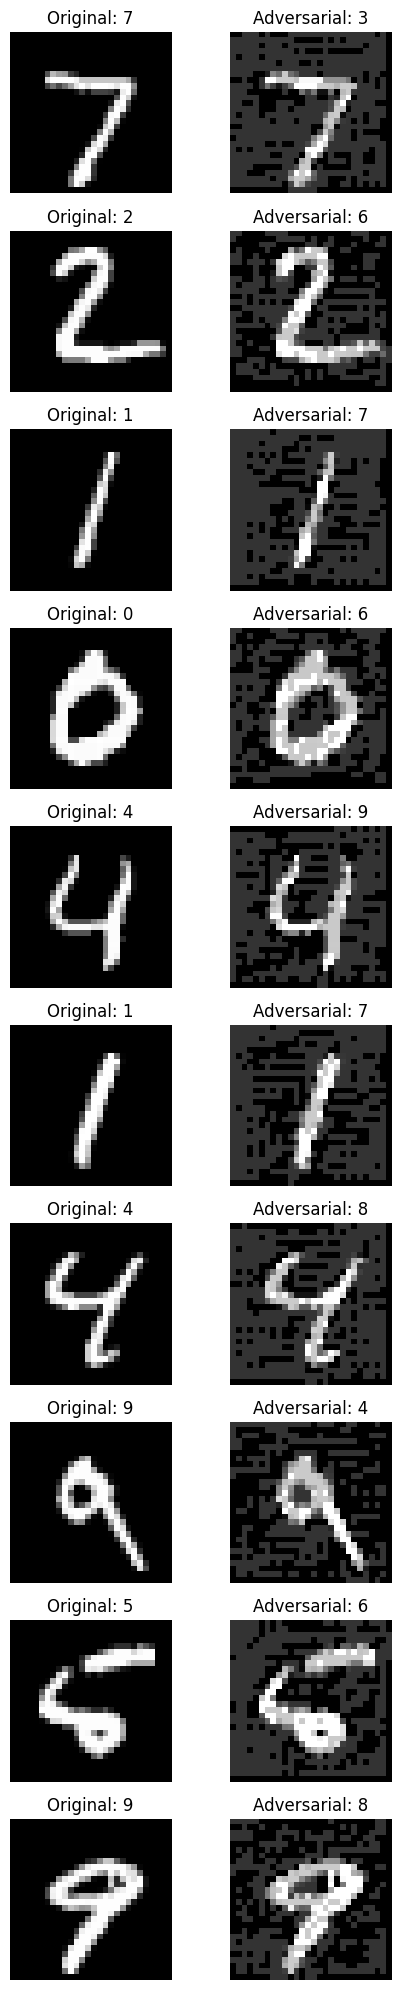

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 3 dimension(s)

In [ ]:
# Adversarial Robustness on MNIST with FGSM Attack

# 1. Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# 2. Load and preprocess MNIST
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    y_train_cat = to_categorical(y_train, 10)
    y_test_cat = to_categorical(y_test, 10)
    return x_train, y_train_cat, x_test, y_test_cat, y_test

x_train, y_train_cat, x_test, y_test_cat, y_test = load_data()

# 3. Build CNN model
def build_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# 4. Train model
model.fit(x_train, y_train_cat, epochs=5, batch_size=128, validation_split=0.1)

# 5. Evaluate on clean test data
loss, acc = model.evaluate(x_test, y_test_cat)
print("Test Accuracy (clean):", acc)

# 6. FGSM Attack Implementation
def fgsm_attack(image, label, model, epsilon=0.1):
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)))
    label = tf.convert_to_tensor(label.reshape((1, 10)))
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adversarial_image = image + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    return adversarial_image.numpy().squeeze()

# 7. Generate and visualize 10 adversarial examples
examples = []
for i in range(10):
    adv = fgsm_attack(x_test[i], y_test_cat[i], model, epsilon=0.2)
    examples.append((x_test[i].squeeze(), adv, y_test[i]))

fig, axes = plt.subplots(10, 2, figsize=(5, 20))
for i, (orig, adv, label) in enumerate(examples):
    axes[i, 0].imshow(orig, cmap="gray")
    axes[i, 0].set_title(f"Original: {label}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(adv, cmap="gray")
    pred = np.argmax(model.predict(adv.reshape(1, 28, 28, 1)))
    axes[i, 1].set_title(f"Adversarial: {pred}")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()

# 8. Adversarial Training
x_adv = np.array([fgsm_attack(x, y, model, epsilon=0.2) for x, y in zip(x_train[:10000], y_train_cat[:10000])])
y_adv = y_train_cat[:10000]

x_combined = np.concatenate([x_train[:10000], x_adv])
y_combined = np.concatenate([y_train_cat[:10000], y_adv])

model_adv = build_model()
model_adv.fit(x_combined, y_combined, epochs=5, batch_size=128, validation_split=0.1)

# 9. Evaluate on clean and adversarial test data
clean_acc = model_adv.evaluate(x_test, y_test_cat, verbose=0)[1]
x_test_adv = np.array([fgsm_attack(x, y, model_adv, epsilon=0.2) for x, y in zip(x_test[:1000], y_test_cat[:1000])])
y_test_adv = y_test_cat[:1000]
adv_acc = model_adv.evaluate(x_test_adv, y_test_adv, verbose=0)[1]

print("After Adversarial Training:")
print("Clean Accuracy:", clean_acc)
print("Adversarial Accuracy:", adv_acc)


In [12]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train.csv to train (1).csv
User uploaded file "train (1).csv" with length 76775041 bytes


Shape of df: (32696, 785)
x_train shape: (26156, 28, 28, 1)
x_test shape: (6540, 28, 28, 1)
x_test shape: (6540, 28, 28, 1)
x_test_adv shape: (10, 28, 28, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8102 - loss: 0.6655 - val_accuracy: 0.9465 - val_loss: 0.1848
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9646 - loss: 0.1264 - val_accuracy: 0.9637 - val_loss: 0.1208
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9791 - loss: 0.0730 - val_accuracy: 0.9767 - val_loss: 0.0915
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9822 - loss: 0.0551 - val_accuracy: 0.9733 - val_loss: 0.0886
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9896 - loss: 0.0377 - val_accuracy: 0.9759 - val_loss: 0.0865
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9768 - loss: nan
Test Accuracy (after adversarial training): 0.9775229096412659
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0107
Adversarial Accuracy (after adversarial training): [0.010689239017665386, 1.0]


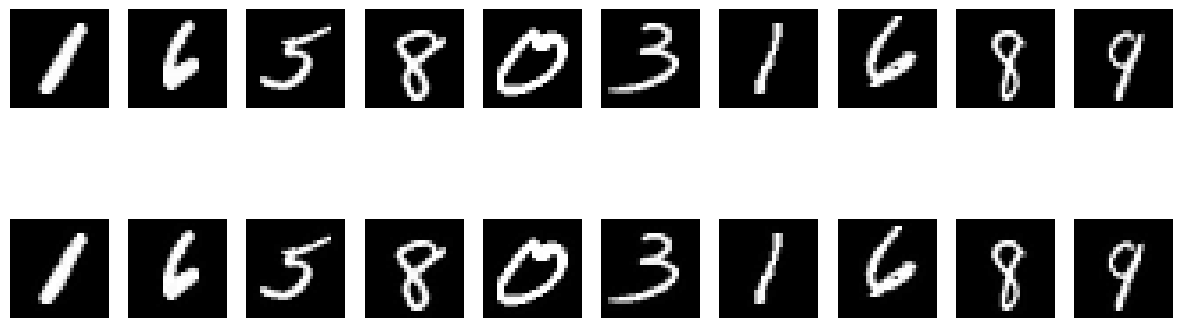

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 1. Chargement et prétraitement des données depuis train.csv
df = pd.read_csv("train.csv")
print(f"Shape of df: {df.shape}")  # Vérification des dimensions du DataFrame

y = df["label"].values
X = df.drop("label", axis=1).values

X = X.astype("float32") / 255.0
X = X.reshape(-1, 28, 28, 1)  # Changement de forme pour l'image
y_cat = to_categorical(y, 10)

# 2. Division manuelle des données train/test
train_size = int(0.8 * X.shape[0])  # Utilisation de 80% des données pour l'entraînement
x_train = X[:train_size]
y_train_cat = y_cat[:train_size]
x_test = X[train_size:]
y_test_cat = y_cat[train_size:]
y_test = y[train_size:]

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

# 3. Construction du modèle CNN
def build_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# 5. Générer des exemples adversariaux avec un epsilon plus petit
def generate_adversarial_examples(model, x, y, epsilon=0.01):  # Réduit epsilon
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)

    x_adv = x.numpy()  # Copie des images d'origine avant perturbation

    model.trainable = True

    with tf.GradientTape() as tape:
        tape.watch(x)
        predictions = model(x)
        loss = tf.keras.losses.categorical_crossentropy(y, predictions)

    gradients = tape.gradient(loss, x)
    perturbations = epsilon * tf.sign(gradients)

    # Clipper les gradients pour éviter les valeurs trop grandes
    perturbations = tf.clip_by_value(perturbations, -0.3, 0.3)  # Limite la perturbation

    x_adv = x + perturbations
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)  # Limiter les valeurs entre 0 et 1

    return x_adv.numpy()

# Générer 10 exemples adversariaux
x_test_adv = generate_adversarial_examples(model, x_test[:10], y_test_cat[:10], epsilon=0.01)

# Vérification des dimensions des données
print(f"x_test shape: {x_test.shape}")
print(f"x_test_adv shape: {x_test_adv.shape}")

# Prédictions sur les images adversariales
predictions_adv = model.predict(x_test_adv, batch_size=128)

# 7. Réentraîner le modèle avec des exemples adversariaux
x_train_combined = np.concatenate((x_train, x_test_adv), axis=0)
y_train_combined = np.concatenate((y_train_cat, y_test_cat[:10]), axis=0)

model = build_model()
model.fit(x_train_combined, y_train_combined, epochs=5, batch_size=128, validation_split=0.1)

# 8. Évaluation du modèle sur le jeu de test normal
loss, acc = model.evaluate(x_test, y_test_cat)
print("Test Accuracy (after adversarial training):", acc)

# 9. Vérification de l'impact sur les exemples adversariaux
acc_adv = model.evaluate(x_test_adv, y_test_cat[:10])
print("Adversarial Accuracy (after adversarial training):", acc_adv)

# Affichage des exemples adversariaux après les prédictions
fig, axs = plt.subplots(2, 10, figsize=(15, 5))
for i in range(10):
    axs[0, i].imshow(x_test[i].reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(x_test_adv[i].reshape(28, 28), cmap='gray')
    axs[1, i].axis('off')

plt.show()
